In [1]:
%matplotlib inline
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad, simps
from astropy.table import Table, vstack
from astropy.io import fits
import glob
import os
import string
import time

# 1) 2016-06-22: Post-processing and cross-checking photometry 1st COSMOSNAP run.

In [3]:
%%time
photometry = Table.read("/share/splinter/moraes/Dedale_Project/2016-06-13_simulated_catalogs/" +
                        "2016-06-20_all_filters_corrected_spectra/2016-06-22_cosmossnap_photometry.out",
                        format="ascii")

CPU times: user 2min 38s, sys: 4.95 s, total: 2min 43s
Wall time: 2min 43s


In [8]:
print(photometry.colnames)

['Id', 'SpcExt', 'type', 'Mod', 'z', 'E', 'DMz', 'MNUV', 'Mstar', 'Half_light_radius', 'ROII', 'Mabs_des_g', 'Mapp_des_g', 'Msed_des_g', 'Ran_des_g', 'Err_des_g', 'Mabs_des_r', 'Mapp_des_r', 'Msed_des_r', 'Ran_des_r', 'Err_des_r', 'Mabs_des_i', 'Mapp_des_i', 'Msed_des_i', 'Ran_des_i', 'Err_des_i', 'Mabs_des_z', 'Mapp_des_z', 'Msed_des_z', 'Ran_des_z', 'Err_des_z', 'Mabs_des_y', 'Mapp_des_y', 'Msed_des_y', 'Ran_des_y', 'Err_des_y', 'Mabs_euclid_vis', 'Mapp_euclid_vis', 'Msed_euclid_vis', 'Ran_euclid_vis', 'Err_euclid_vis', 'Mabs_euclid_J', 'Mapp_euclid_J', 'Msed_euclid_J', 'Ran_euclid_J', 'Err_euclid_J', 'Mabs_euclid_H', 'Mapp_euclid_H', 'Msed_euclid_H', 'Ran_euclid_H', 'Err_euclid_H', 'Mabs_euclid_Y', 'Mapp_euclid_Y', 'Msed_euclid_Y', 'Ran_euclid_Y', 'Err_euclid_Y', 'Mabs_lsst_u', 'Mapp_lsst_u', 'Msed_lsst_u', 'Ran_lsst_u', 'Err_lsst_u', 'Mabs_lsst_g', 'Mapp_lsst_g', 'Msed_lsst_g', 'Ran_lsst_g', 'Err_lsst_g', 'Mabs_lsst_r', 'Mapp_lsst_r', 'Msed_lsst_r', 'Ran_lsst_r', 'Err_lsst_r', 'Mab

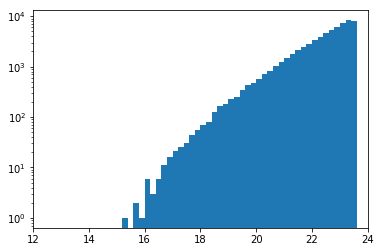

In [16]:
deslike = photometry[photometry["Err_des_i"] < 0.0543]
_ = plt.hist(deslike["Mapp_des_i"], bins=np.arange(12, 30, 0.2))
plt.xlim(12, 24)
plt.yscale("log")

64431


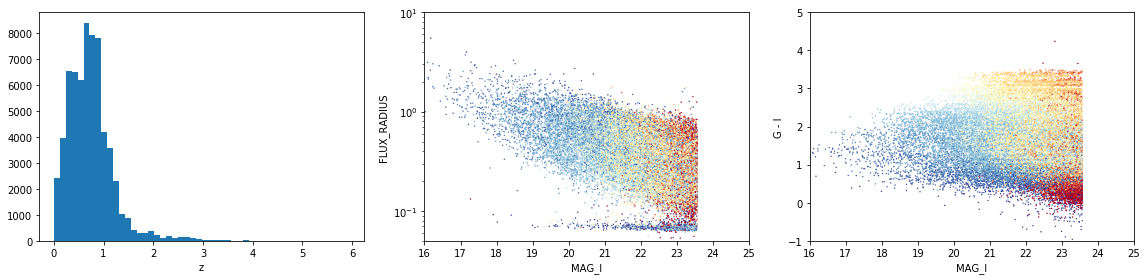

In [43]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

_ = ax1.hist(deslike["z"], bins=50)
ax1.set_xlabel("z")

print(len(deslike))

ax2.scatter(deslike["Mapp_des_i"], 0.03*deslike['Half_light_radius'], c=deslike["z"],
            cmap=plt.cm.RdYlBu_r, vmin=0, vmax=1.5, s=2, lw=0)
ax2.set_xlim(16, 25)
ax2.set_ylim(5e-2, 10)
ax2.set_xlabel("MAG_I")
ax2.set_ylabel("FLUX_RADIUS")
ax2.set_yscale("log")

ax3.scatter(deslike["Mapp_des_i"], deslike["Mapp_des_g"] - deslike["Mapp_des_i"], c=deslike["z"],
            cmap=plt.cm.RdYlBu_r, vmin=0, vmax=1.5, s=2, lw=0)
ax3.set_xlim(16, 25)
ax3.set_ylim(-1, 5)
ax3.set_xlabel("MAG_I")
ax3.set_ylabel("G - I")
fig.tight_layout()

/share/splinter/cosmos/modules/oct_2016/install_dir/anaconda-2-4.2.0/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


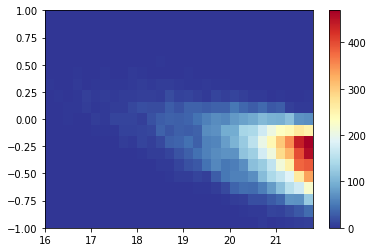

In [35]:
_ = plt.hist2d(deslike["Mapp_des_i"], np.log10(0.03*deslike['Half_light_radius']),
               bins=[np.arange(16, 22, 0.2), np.linspace(-1, 1, 20)],
               cmap=plt.cm.RdYlBu_r)
plt.colorbar()

In [3]:
# Comparing to CS82 stuff
cs82 = Table.read("/share/splinter/moraes/2016-01-25_CS82_combined_products/cs82_morphology_exp.fit", format='fits')
mask = (cs82["IM_NUM"] == 120)
cs82tile = cs82[mask]
mauto = cs82tile["MAG_AUTO"]
merr = cs82tile["MAGERR_AUTO"]

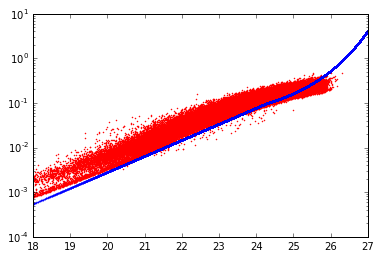

In [13]:
#_ = plt.hist(photometry["Mapp_des_i"], bins=np.arange(18, 30, 0.2), facecolor='blue', alpha=0.2)
#_ = plt.hist(photometry["Mapp_lsst_i"], bins=np.arange(18, 30, 0.2), facecolor='red', alpha=0.2)
#_ = plt.hist(photometry["Mapp_panStarrs_i"], bins=np.arange(18, 30, 0.2), facecolor='green', alpha=0.2)
#plt.figure()
#_ = plt.hist(mauto, bins=np.arange(18, 30, 0.2))
plt.figure()
plt.plot(mauto, merr, 'r.', markersize=2)
plt.plot(photometry["Mapp_des_i"], photometry["Err_des_i"], 'b.', alpha=0.2, markersize=2)
#plt.plot(photometry["Mapp_lsst_i"], photometry["Err_lsst_i"], 'ro', alpha=0.2)
#plt.plot(photometry["Mapp_panStarrs_i"], photometry["Err_panStarrs_i"], 'go', alpha=0.2)
plt.xlim(18, 27)
plt.ylim(1e-4, 1e1)
plt.yscale("log")
#plt.ylabel("$\prop$ SNR$^{-1}$")
plt.savefig("/home/moraes/cosmossnap_des_vs_cs82.png")

In [ ]:
filelist = glob.glob("/share/splinter/moraes/Dedale_Project/2016-06-13_simulated_catalogs/" +
            "2016-06-20_all_filters_corrected_spectra/2016-06-20_*spec_*.fits")
filelist.sort()

In [ ]:
for specfile in filelist:
    plt.figure()
    plt.title(os.path.basename(specfile[-10:]))
    hdulist = fits.open(specfile)
    idxs = np.random.randint(1, 1000, size=7).tolist()
    for idx in idxs:
        hdu = hdulist[idx]
        spectra = hdu.data
        plt.plot(spectra.field('lambda'), spectra.field('flux'))
    plt.xlim(3000, 20500)

# Checking redshift distribution

In [ ]:
_ = plt.hist(photometry["z"], bins=np.arange(0, 6, 0.1))

In [ ]:
np.sum(photometry["z"] < 0.7)

In [ ]:
zsmall = photometry[photometry["z"] < 0.7]
specIDs = zsmall["SpcExt"]
len(np.random.choice(len(specIDs), size=len(specIDs)//10, replace=False))

# 2) 2016-09 to 2017-01: Postprocessing COSMOSNAP spectra for different analysis steps

In [2]:
def get_digits(name):
    translator = string.maketrans('', '')
    digit_trans = translator.translate(translator, string.digits)
    digits = name.translate(translator, digit_trans)
    return digits


def blueshift(spectrum, z):
    spectrum[:, 0] /= (1 + z)
    return spectrum


def get_maxfluxHa(spectrum):
    Hamask = (spectrum[:, 0] > 6540) & (spectrum[:, 0] < 6580)
    fluxHa = spectrum[Hamask]
    maxfluxHa = np.sum(fluxHa[:, 1])
    return maxfluxHa


def resample_and_integrate(spectrum, Lmin, Lmax, dL, resamp_prec=100):
    assert Lmin >= spectrum[:, 0].min(), "Lmin must be >= than min spectral wavelength"
    assert Lmax <= spectrum[:, 0].max(), "Lmax must be <= than max spectral wavelength"
    
    spline = interp1d(spectrum[:, 0], spectrum[:, 1])
    
    x = np.arange(Lmin, Lmax, dL/resamp_prec)
    xdata = x.reshape(int((Lmax - Lmin)/dL), resamp_prec)
    integrated_spec = simps(spline(xdata), dx=dL/resamp_prec, axis=1)
    
    out_spectrum = np.array([np.arange(Lmin + dL/2, Lmax + dL/2, dL), integrated_spec]).T
    assert out_spectrum.shape == ((Lmax - Lmin)/dL, 2)
    del spectrum
    
    return out_spectrum

## 2.A) 2016-09-23: Main function for clean and noisy templates - Data for 1st report

In [26]:
def main_annual_report(folder, zmax, zfraction, Lmin, Lmax, dL, resamp_prec=100,
         outpath="./templates.csv", noise=[], flux_thresh=None):
    
    assert isinstance(noise, (list, tuple)), "noise must be a list or a tuple of ints or floats"

    # Create photometric filename list
    fnames_spec = glob.glob(os.path.join(folder, "*spec_*.fits"))
    fnames_phot = glob.glob(os.path.join(folder, "*.out"))
    fnames_spec.sort()
    fnames_phot.sort()
    assert len(fnames_spec) == len(fnames_phot), "Spectroscopic and photometric files don't match"
    
    # Create astropy table and resampled wavelength column
    wavelengths = np.arange(Lmin + dL/2, Lmax + dL/2, dL)
    
    # Initialize output tables
    colnames = []
    colnames.append("lambda")

    template_clean = []
    template_clean.append(wavelengths)
    
    templates_noise = []
    for n in range(len(noise)):
        template = []
        template.append(wavelengths)
        
        templates_noise.append(template)
    
    for i, (specname, photname) in enumerate(zip(fnames_spec, fnames_phot)):
        t0 = time.time()
        # Assert files are from the same run
        assert get_digits(specname) == get_digits(photname), "Ordering didn't work, files are not the same"

        # From photometry output, choose a subset of {zfraction}% spectra ID at redshift < {zmax}
        # and Halpha flux >= {flux_thresh}
        phot = Table.read(photname, format="ascii")
        lowz = phot[phot["z"] < zmax]
        if flux_thresh is not None:
            assert isinstance(flux_thresh, (float, int)), "flux_thresh must be an int or float"
            lowz = lowz[lowz["Flux_Ha"] >= flux_thresh]
        if len(lowz) == 0:
            continue
            
        np.random.seed(i)
        frac_idx = np.random.choice(np.arange(len(lowz)), size=int(len(lowz)*zfraction), replace=False)
        frac_lowz = lowz[frac_idx]
        print(len(frac_lowz))
        entries = frac_lowz["SpcExt"]
        specIDs = frac_lowz["Id"]
        redshifts = frac_lowz["z"]
        
        hdulist = fits.open(specname)
        
        for specID, entry, z in zip(specIDs, entries, redshifts):
            hdu = hdulist[entry]
            assert int(hdu.name) == specID, ("Spec ID from phot and spec cats " +
                                             "doesnt'match: %d vs %d" % (int(hdu.name), specID))
            hdudata = hdu.data
            spectrum = np.array([hdudata.field("lambda"), hdudata.field("flux")]).T
            spectrum = blueshift(spectrum, z)            
            spectrum = resample_and_integrate(spectrum, Lmin, Lmax, dL,
                                              resamp_prec=resamp_prec)
            colnames.append(str(specID))
            template_clean.append(spectrum[:, 1])
            
            for sigma, template_noise in zip(noise, templates_noise):
                spectrum_noise = spectrum[:, 1] + np.random.normal(0, sigma, size=len(spectrum[:, 1]))
                template_noise.append(spectrum_noise)
        t1 = time.time() - t0        
        print("File %d done in %.1f seconds!" % (i, t1))
    # Save table to outfolder
    outclean = os.path.join(os.path.dirname(outpath), "clean_" + os.path.basename(outpath))
    np.savetxt(outclean, np.array(template_clean).T, delimiter=",", header=",".join(colnames), comments="")
    
    for i, template_noise in enumerate(templates_noise):
        outnoise = os.path.join(os.path.dirname(outpath), "noise" + str(i) + "_" + os.path.basename(outpath))
        np.savetxt(outnoise, np.array(template_noise).T, delimiter=",", header=",".join(colnames), comments="")
        
    return None

In [ ]:
main_annual_report(folder="/share/splinter/moraes/Dedale_Project/2016-06-13_simulated_catalogs/2016-09-06_euclid_run/",
     zmax=1.0, zfraction=0.5, Lmin=1250, Lmax=20000, dL=5, resamp_prec=100,
     outpath="/share/splinter/moraes/Dedale_Project/2016-06-13_simulated_catalogs/2016-09-06_euclid_run/templates.csv",
     noise=[9.1187e-18, 8.5714e-17, 3e-16],
     flux_thresh=1e-16)

## 2.B) 2017-01-16: Relaunching run for Joana without resampling - for photo-zs?

The changes were to comment out the resampling function and the full section where noise was applied. Also needed to get rid of the loop saving the noise files.

In [ ]:
def main_noresampling_forJoana_jan2017(folder, zmax, zfraction, Lmin, Lmax, dL, resamp_prec=100,
         outpath="./templates.csv", noise=[], flux_thresh=None):
    
    assert isinstance(noise, (list, tuple)), "noise must be a list or a tuple of ints or floats"

    # Create photometric filename list
    fnames_spec = glob.glob(os.path.join(folder, "*spec_*.fits"))
    fnames_phot = glob.glob(os.path.join(folder, "*.out"))
    fnames_spec.sort()
    fnames_phot.sort()
    assert len(fnames_spec) == len(fnames_phot), "Spectroscopic and photometric files don't match"
    
    # Create astropy table and resampled wavelength column
    wavelengths = np.arange(Lmin + dL/2, Lmax + dL/2, dL)
    
    # Initialize output tables
    colnames = []
    colnames.append("lambda")

    template_clean = []
    template_clean.append(wavelengths)
    
    templates_noise = []
    for n in range(len(noise)):
        template = []
        template.append(wavelengths)
        
        templates_noise.append(template)
    
    # ---- For Joana - 2017-01-16: Spec and phot output initializers    
    outspec_hdulist = fits.HDUList()
    outphot_list = []
    # --------------------------------
    
    for i, (specname, photname) in enumerate(zip(fnames_spec, fnames_phot)):
        t0 = time.time()
        # Assert files are from the same run
        assert get_digits(specname) == get_digits(photname), "Ordering didn't work, files are not the same"

        # From photometry output, choose a subset of {zfraction}% spectra ID at redshift < {zmax}
        # and Halpha flux >= {flux_thresh}
        phot = Table.read(photname, format="ascii")
        lowz = phot[phot["z"] < zmax]
        if flux_thresh is not None:
            assert isinstance(flux_thresh, (float, int)), "flux_thresh must be an int or float"
            lowz = lowz[lowz["Flux_Ha"] >= flux_thresh]
        if len(lowz) == 0:
            continue
            
        np.random.seed(i)
        frac_idx = np.random.choice(np.arange(len(lowz)), size=int(len(lowz)*zfraction), replace=False)
        frac_lowz = lowz[frac_idx]
        print(len(frac_lowz))
        entries = frac_lowz["SpcExt"]
        specIDs = frac_lowz["Id"]
        redshifts = frac_lowz["z"]
        
        # ---- For Joana - 2017-01-16: Save photometry to an output table
        outphot_list.append(frac_lowz)
        # ----------------------------
        
        hdulist = fits.open(specname)
        
        for specID, entry, z in zip(specIDs, entries, redshifts):
            hdu = hdulist[entry]
            assert int(hdu.name) == specID, ("Spec ID from phot and spec cats " +
                                             "doesnt'match: %d vs %d" % (int(hdu.name), specID))
            # ---- For Joana - 2017-01-16: Add spectrum hdu back to an output table
            outspec_hdulist.append(hdu)
            # ----------
            hdudata = hdu.data
            spectrum = np.array([hdudata.field("lambda"), hdudata.field("flux")]).T
            spectrum = blueshift(spectrum, z)            
            spectrum = resample_and_integrate(spectrum, Lmin, Lmax, dL,
                                              resamp_prec=resamp_prec)
            colnames.append(str(specID))
            template_clean.append(spectrum[:, 1])
            
            for sigma, template_noise in zip(noise, templates_noise):
                spectrum_noise = spectrum[:, 1] + np.random.normal(0, sigma, size=len(spectrum[:, 1]))
                template_noise.append(spectrum_noise)
        t1 = time.time() - t0        
        print("File %d done in %.1f seconds!" % (i, t1))
    # Save table to outfolder
    outclean = os.path.join(os.path.dirname(outpath), "clean_" + os.path.basename(outpath))
    np.savetxt(outclean, np.array(template_clean).T, delimiter=",", header=",".join(colnames), comments="")
    
    #for i, template_noise in enumerate(templates_noise):
    #    outnoise = os.path.join(os.path.dirname(outpath), "noise" + str(i) + "_" + os.path.basename(outpath))
    #    np.savetxt(outnoise, np.array(template_noise).T, delimiter=",", header=",".join(colnames), comments="")
    
    # ---- For Joana - 2017-01-16: Save full spectrum and phot table
    outspec_path = os.path.join(os.path.dirname(outpath), os.path.basename(outpath) + "_specs.fits")
    outspec_hdulist.writeto(outspec_path)
    outphot = vstack(outphot_list)
    outphot.write(os.path.join(os.path.dirname(outpath), os.path.basename(outpath) + "_phot.fits"))
    # -----------------
        
    return None

In [27]:
main_noresampling_forJoana_jan2017(
    folder="/share/splinter/moraes/Dedale_Project/2016-06-13_simulated_catalogs/2016-09-06_euclid_run/",
    zmax=1.0, zfraction=0.5, Lmin=1250, Lmax=20000, dL=5, resamp_prec=100,
    outpath=("/share/splinter/moraes/Dedale_Project/2016-06-13_simulated_catalogs/" +
             "2017-01-16_euclid_run_euclid_noresampling_toJoana"),
    noise=[9.1187e-18, 8.5714e-17, 3e-16],
    flux_thresh=1e-16)

213
File 0 done in 25.2 seconds!
207
File 1 done in 24.7 seconds!
207
File 2 done in 25.4 seconds!
213
File 3 done in 25.5 seconds!
195
File 4 done in 26.6 seconds!
232
File 5 done in 30.8 seconds!
245
File 6 done in 31.7 seconds!
300
File 7 done in 31.2 seconds!
230
File 8 done in 30.8 seconds!
238
File 9 done in 27.9 seconds!
239
File 10 done in 31.1 seconds!
199
File 11 done in 30.2 seconds!
222
File 12 done in 26.5 seconds!
175
File 13 done in 30.9 seconds!
232
File 14 done in 31.7 seconds!
230
File 15 done in 31.4 seconds!
242
File 16 done in 31.0 seconds!
247
File 17 done in 30.8 seconds!
211
File 18 done in 31.3 seconds!
282
File 19 done in 31.5 seconds!
263
File 20 done in 31.6 seconds!
222
File 21 done in 30.9 seconds!
279
File 22 done in 33.2 seconds!
231
File 23 done in 31.4 seconds!
213
File 24 done in 32.1 seconds!
253
File 25 done in 31.8 seconds!
293
File 26 done in 32.3 seconds!
269
File 27 done in 33.6 seconds!
251
File 28 done in 31.8 seconds!
262
File 29 done in 28.8

## 2.C) 2017-01-26: Adapting runs to include realistic noise from TIPS

The philosophy is to have, as close as possible, what it comes out of the telescope and 2D to 1D processing steps. Shortly describe differences of the code here:

 - I am not blueshifting the spectra.
 - I am not resampling and integrating either, as I expect that TIPS will do the necessary steps to be realistic.
 - I am taking out the previous white noise calculations.
 - I am changing the range of wavelengths that is saved and formatting to TIPS needs.
 - This means each spectrum will be a different FITS file.
 
 __AN IMPORTANT POINT: compared to the codes above, I am changin the way a redshift range is chosen. More specifically, instead of just picking the low-redshift galaxies because they will be blueshifted to 0, I am taking the physically relevant range z = [1.0, 2.0].__

In [9]:
def main_spectra_for_TIPS_jan2017(folder, Lmin, Lmax, dL, resamp_prec=100,
                                  zfraction=None, zmin=1.0, zmax=2.0, flux_thresh=None,
                                  outfolder="./"):
    
    # Create photometric filename list
    fnames_spec = glob.glob(os.path.join(folder, "*spec_*.fits"))
    fnames_phot = glob.glob(os.path.join(folder, "*.out"))
    fnames_spec.sort()
    fnames_phot.sort()
    assert len(fnames_spec) == len(fnames_phot), "Spectroscopic and photometric files don't match"
    
    # Create astropy table and resampled wavelength column
    wavelengths = np.arange(Lmin + dL/2, Lmax + dL/2, dL)
    
    for i, (specname, photname) in enumerate(zip(fnames_spec, fnames_phot)):
        t0 = time.time()
        # Assert files are from the same run
        assert get_digits(specname) == get_digits(photname), "Ordering didn't work, files are not the same"

        # From photometry output, choose a subset of {zfraction}% spectra ID at redshift < {zmax}
        # and Halpha flux >= {flux_thresh}
        phot = Table.read(photname, format="ascii")
        zrange = phot[(phot["z"] >= zmin) & (phot["z"] <= zmax)]
        if flux_thresh is not None:
            assert isinstance(flux_thresh, (float, int)), "flux_thresh must be an int or float"
            zrange = zrange[zrange["Flux_Ha"] >= flux_thresh]
        if len(zrange) == 0:
            continue
        
        if zfraction is not None:
            np.random.seed(i)
            frac_idx = np.random.choice(np.arange(len(zrange)), size=int(len(zrange)*zfraction), replace=False)
            zfrac = zrange[frac_idx]
            print(len(zfrac))
        else:
            zfrac = np.copy(zrange)
            print(len(zfrac))
        entries = zfrac["SpcExt"]
        specIDs = zfrac["Id"]
        redshifts = zfrac["z"]
        
        hdulist = fits.open(specname)
        
        for specID, entry, z in zip(specIDs, entries, redshifts):
            hdu = hdulist[entry]
            assert int(hdu.name) == specID, ("Spec ID from phot and spec cats " +
                                             "doesnt'match: %d vs %d" % (int(hdu.name), specID))
            hdudata = hdu.data
            spectrum = np.array([hdudata.field("lambda"), hdudata.field("flux")]).T
            #spectrum = resample_and_integrate(spectrum, Lmin, Lmax, dL,
            #                                  resamp_prec=resamp_prec)
            #plt.plot(spectrum[:, 0], spectrum[:, 1])
            #plt.yscale("log")
            # Create output hdulist, format to TIPS specifications and save.
            tbhdu = fits.BinTableHDU.from_columns(
                [fits.Column(name='wave', format='D', array=spectrum[:, 0]),
                 fits.Column(name='flux', format='D', array=spectrum[:, 1])])
            outclean = os.path.join(outfolder, "clean_TIPSspec_ID_" + str(specID) + ".fits")
            try:
                tbhdu.writeto(outclean)
            except IOError as e:
                print(e)
                print("Removing older file...")
                os.system("rm " + outclean)
                tbhdu.writeto(outclean)
        t1 = time.time() - t0        
        print("File %d done in %.1f seconds!" % (i, t1))
        break
        
    return None

182
File 0 done in 74.0 seconds!
160
File 1 done in 65.5 seconds!
171
File 2 done in 52.6 seconds!
167
File 3 done in 66.2 seconds!
175
File 4 done in 70.2 seconds!
195
File 5 done in 76.8 seconds!
198
File 6 done in 78.0 seconds!
205
File 7 done in 76.3 seconds!
167
File 8 done in 71.9 seconds!
168
File 9 done in 66.7 seconds!
160
File 10 done in 69.0 seconds!
170
File 11 done in 69.8 seconds!
186
File 12 done in 73.1 seconds!
208
File 13 done in 81.6 seconds!
190
File 14 done in 72.7 seconds!
155
File 15 done in 60.3 seconds!
187
File 16 done in 70.9 seconds!
175
File 17 done in 74.6 seconds!
164
File 18 done in 65.7 seconds!
185
File 19 done in 58.1 seconds!
171
File 20 done in 71.2 seconds!
199
File 21 done in 75.0 seconds!
198
File 22 done in 79.1 seconds!
173
File 23 done in 69.4 seconds!
176
File 24 done in 71.7 seconds!
188
File 25 done in 74.0 seconds!
191
File 26 done in 74.7 seconds!
179
File 27 done in 70.3 seconds!
156
File 28 done in 68.4 seconds!
156
File 29 done in 66.2

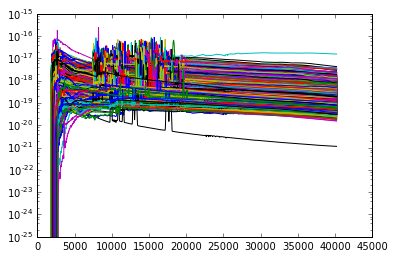

In [43]:
main_spectra_for_TIPS_jan2017(
    folder="/share/splinter/moraes/Dedale_Project/2016-06-13_simulated_catalogs/2016-09-06_euclid_run/",
    zmin=1.0, zmax=2.0, zfraction=0.5,
    Lmin=1250, Lmax=20000, dL=5, resamp_prec=100,
    outfolder=("/share/splinter/moraes/Dedale_Project/2016-06-13_simulated_catalogs/" +
             "2017-02-10_euclid_run_individual_spectra_for_TIPS/"),
    flux_thresh=1e-16)

# 2017-08-25: Generating TIPS sims for full COSMOSSNAP data (Yay!)

This is for the Nice conference and the paper. I may have to rerun this again, but maybe even not. I am not applying any redshift, flux or random selection whatsoever. Could probably refactor the main function, but it would take longer than just letting it run.

In [10]:
main_spectra_for_TIPS_jan2017(
    folder="/share/splinter/moraes/Dedale_Project/2016-06-13_simulated_catalogs/2016-09-06_euclid_run/",
    zmin=0, zmax=10.0, zfraction=None,
    Lmin=1250, Lmax=20000, dL=5, resamp_prec=100,
    outfolder=("/share/splinter/moraes/Dedale_Project/2016-06-13_simulated_catalogs/" +
             "2017-08-25_euclid_Nice_run_individual_spectra_for_TIPS_1/"),
    flux_thresh=None)

9783
File 0 done in 433.7 seconds!


## CROSS_CHECKING EUCLID SPECTRA

In [23]:
test_spec = np.loadtxt("/share/splinter/moraes/Dedale_Project/2016-06-13_simulated_catalogs/" + 
                       "2016-09-06_euclid_run/templates_clean.csv", delimiter=",", skiprows=1)

In [38]:
test_nonoise = np.loadtxt("/share/splinter/moraes/Dedale_Project/2016-06-13_simulated_catalogs/" + 
                       "2016-09-06_euclid_run/templates_midsnr.csv", delimiter=",", skiprows=1)

6
7


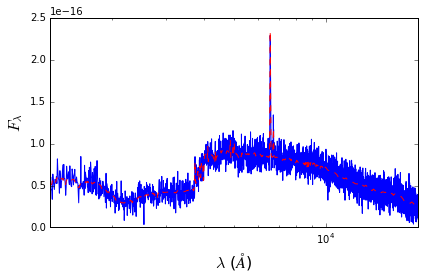

In [36]:
for col in range(6, len(test_spec[0])):
    print(col)
    if col > 6:
        break
    plt.figure()
    plt.plot(test_nonoise[:, 0], test_nonoise[:, col], "b")
    plt.plot(test_spec[:, 0], test_spec[:, col], "r--")
    #plt.axvline(6563, color="k", linestyle=":")
    plt.xscale("log")
    #plt.yscale("log")
    plt.xlim(1.25e3, 2e4)
    plt.xlabel("$\lambda$ ($\AA$)", fontsize=16)
    plt.ylabel("$F_\lambda$", fontsize=16)
plt.tight_layout()
plt.savefig("/home/moraes/spectrum_midsnr.png")

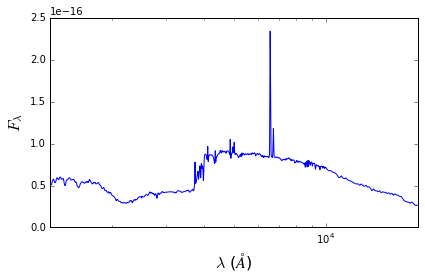

In [37]:
for col in range(6, len(test_spec[0])):
    if col > 6:
        break
    plt.figure()
    #plt.plot(test_nonoise[:, 0], test_nonoise[:, col], "b")
    plt.plot(test_spec[:, 0], test_spec[:, col], "b")
    #plt.axvline(6563, color="k", linestyle=":")
    plt.xscale("log")
    #plt.yscale("log")
    plt.xlabel("$\lambda$ ($\AA$)", fontsize=16)
    plt.ylabel("$F_\lambda$", fontsize=16)
    plt.xlim(1.25e3, 2e4)
plt.tight_layout()
plt.savefig("/home/moraes/example_spectrum.png")

In [ ]:
ls /share/splinter/moraes/Dedale_Project/2016-06-13_simulated_catalogs/2016-09-06_euclid_run/*csv

In [ ]:
!head -n 1 /share/splinter/moraes/Dedale_Project/2016-06-13_simulated_catalogs/2016-09-06_euclid_run/clean_templates.csv | tr -cd , | wc -c

In [ ]:
load_ext line_profiler

In [ ]:
lprun -f main main(folder="/share/splinter/moraes/Dedale_Project/2016-06-13_simulated_catalogs/2016-09-06_euclid_run/",zmax=1.0, zfraction=0.5, Lmin=1250, Lmax=20000, dL=5, resamp_prec=100,outpath="/share/splinter/moraes/Dedale_Project/2016-06-13_simulated_catalogs/2016-09-06_euclid_run/templates.csv", noise=[9.1187e-18, 8.5714e-17, 3e-16],flux_thresh=1e-16)

# Checking spectra amplitude normalization

In [ ]:
specname = "/share/splinter/moraes/Dedale_Project/2016-06-13_simulated_catalogs/2016-09-06_euclid_run/2016-09-06_euclid_run_spectra_spec_16.fits"

In [ ]:
hdulist=fits.open(specname)

In [ ]:
spectrum = hdulist["733850"].data

In [ ]:
np.random.normal(scale=(3/3.5)*1e-16, size=len(spectrum))

In [ ]:
def mab(fL, Lc, dL):
    term1 = -2.5*np.log10(fL*dL)
    term2 = 2.5*np.log10(0.1088*(dL/(Lc*Lc - dL*dL/4)))
    return term1 + term2

In [ ]:
mab(1.9e-17, 6250, 1500)

In [ ]:
plt.plot(photometry["z"], photometry["Flux_Ha"], "b.", linestyle="")
plt.yscale("log")

In [ ]:
spec16 = fits.open("/share/splinter/moraes/Dedale_Project/2016-06-13_simulated_catalogs/2016-09-06_euclid_run/2016-09-06_euclid_run_spectra_spec_16.fits")
phot16 = Table.read("/share/splinter/moraes/Dedale_Project/2016-06-13_simulated_catalogs/2016-09-06_euclid_run/2016-09-06_euclid_run_spectra_16.out", format="ascii")

In [ ]:
phot16[:10]["Id", "Flux_Ha", "Conti_Ha"]

In [ ]:
spectra = [spec16[int(idspec)].data for idspec in phot16[:10]["SpcExt"].data]

In [ ]:
phot16["Id", "SpcExt"]

In [ ]:
int(spec16[11].name)

In [ ]:
for lambdaHa, fluxHa, spectrum in zip(phot16[:10]["Lambda_Ha"], phot16[:10]["Flux_Ha"], spectra):
    plt.figure()
    plt.plot(spectrum.field("lambda"), spectrum.field("flux"), ".")
    plt.plot(lambdaHa, fluxHa, "s")
    plt.axvline(lambdaHa, linestyle="--", color="k")
    plt.xlim(lambdaHa-10, lambdaHa+10)

In [ ]:
test_spec = Table.read("/share/splinter/moraes/Dedale_Project/2016-06-13_simulated_catalogs/" + 
                       "2016-09-06_euclid_run/templates_clean.csv", format="ascii.basic", delimiter=",")

In [ ]:
len(test_spec.colnames)

In [29]:
joana_phot = Table.read("/share/splinter/moraes/Dedale_Project/2016-06-13_simulated_catalogs/2017-01-16_euclid_run_euclid_noresampling_toJoana_phot.fits")

In [31]:
joana_speclist = fits.open("/share/splinter/moraes/Dedale_Project/2016-06-13_simulated_catalogs/2017-01-16_euclid_run_euclid_noresampling_toJoana_specs.fits")